In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d omkargurav/face-mask-dataset
!unzip "/content/face-mask-dataset.zip"

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [4]:
# count the number of images in the respective classes 1-Brain Tumor 0-Healthy
ROOT_DIR="/content/data"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))

number_of_images.items()

dict_items([('without_mask', 3828), ('with_mask', 3725)])

# we will split the data such that
  * 70 % for training
  * 15 % for validation
  * 15 % for testing
  

In [5]:
def dataFolder(p,split):  #p:path
  # we will create a train folder
  if not os.path.exists("./"+p):
     os.mkdir("./"+p)

     for dir in os.listdir(ROOT_DIR):
        os.makedirs("./"+p+"/"+dir)
        for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR,dir)),
                                    size=(math.floor(split*number_of_images[dir])-5),
                                    replace=False ):
            O=os.path.join(ROOT_DIR,dir,img) # path # O: orginal path
            D=os.path.join("./"+p,dir) # path # D: Destination
            shutil.copy(O,D)
            #os.remove(O)
  else:
     print(f"the {p} folder exists ")


In [6]:
dataFolder("train",0.7)

In [7]:
dataFolder("dev",0.15)
dataFolder("test",0.15)

In [8]:
ROOT_DIR="/content/train"
number_of_train_image={}

for dir in os.listdir(ROOT_DIR):
  number_of_train_image[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))

number_of_train_image.items()

dict_items([('without_mask', 2674), ('with_mask', 2602)])

# Model Build

In [9]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras

In [10]:
# CNN Model

model = Sequential()

model.add(Conv2D(filters=64 , kernel_size=(3,3), activation='relu', input_shape=(224,224,3) )) # can ba add: padding='same'

model.add(Conv2D(filters=64 , kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2) ))

model.add(Conv2D(filters=64 , kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2) ))

model.add(Conv2D(filters=128 , kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2) ))

model.add(Dropout(rate=0.25) )

model.add(Flatten())
model.add(Dense(units=64, activation = 'relu'))
model.add(Dropout(rate=0.25) )
model.add(Dense(units=1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [11]:
model.compile(optimizer='adam',
              loss=keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [12]:
from keras.applications.mobilenet import MobileNet, preprocess_input

def preprocessingImages1(path):
  """
  input : Path
  output: Pre processing images
  """
  image_data=ImageDataGenerator(zoom_range=0.2,shear_range=0.2, rescale=1/255, horizontal_flip=True)
  #image_data=ImageDataGenerator(zoom_range=0.2,shear_range=0.2, preprocessing_function=preprocess_input, horizontal_flip=True) # for transformer learning

  image=image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size=64, class_mode='binary')

  return image

In [13]:
path="/content/train"
train_data=preprocessingImages1(path)

Found 5276 images belonging to 2 classes.


In [14]:
def preprocessingImages2(path):
  """
  input : Path
  output: Pre processing
  """
  image_data=ImageDataGenerator(rescale=1/255)
  #image_data=ImageDataGenerator(preprocessing_function=preprocess_input) # for transformer learning
  image=image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size=64, class_mode='binary')

  return image

In [15]:
path="/content/test"
test_data=preprocessingImages2(path)

Found 1122 images belonging to 2 classes.


In [16]:
path="/content/dev"
val_data=preprocessingImages2(path)

Found 1122 images belonging to 2 classes.


In [17]:
# Early stopping and model check point

from keras.callbacks import ModelCheckpoint, EarlyStopping

# Eaarly stoppping

es=EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=5, verbose=1, mode='auto')

# model check point
mc=ModelCheckpoint(monitor='val_accuracy', filepath="./bestmodel.h5", verbose=1,save_best_only=True, mode='auto')

cd=[es,mc]


# Model Training


In [18]:
hist = model.fit_generator(generator=train_data,
                         steps_per_epoch=8,
                         epochs=30,
                         verbose=1,
                         validation_data=val_data,
                         validation_steps=14,
                         callbacks=cd )


Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.8226 - accuracy: 0.5462
Epoch 1: val_accuracy improved from -inf to 0.49442, saving model to ./bestmodel.h5
8/8 [==============================] - 41s 2s/step - loss: 0.8226 - accuracy: 0.5462 - val_loss: 0.7076 - val_accuracy: 0.4944
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.6035
Epoch 2: val_accuracy improved from 0.49442 to 0.53795, saving model to ./bestmodel.h5
8/8 [==============================] - 14s 2s/step - loss: 0.6652 - accuracy: 0.6035 - val_loss: 0.6524 - val_accuracy: 0.5379
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.5667 - accuracy: 0.7207
Epoch 3: val_accuracy improved from 0.53795 to 0.69754, saving model to ./bestmodel.h5
8/8 [==============================] - 14s 2s/step - loss: 0.5667 - accuracy: 0.7207 - val_loss: 0.6431 - val_accuracy: 0.6975
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 

In [19]:
 # chnage the patinece to 5 and run it again it'll improve

In [21]:
# Model Graphical Interpretation
h=hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

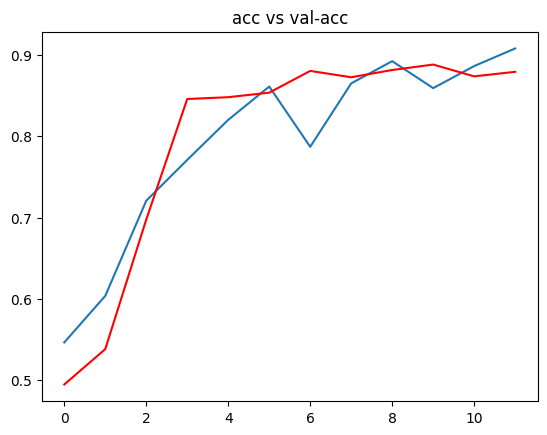

In [22]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c="red")

plt.title("acc vs val-acc")
plt.show()

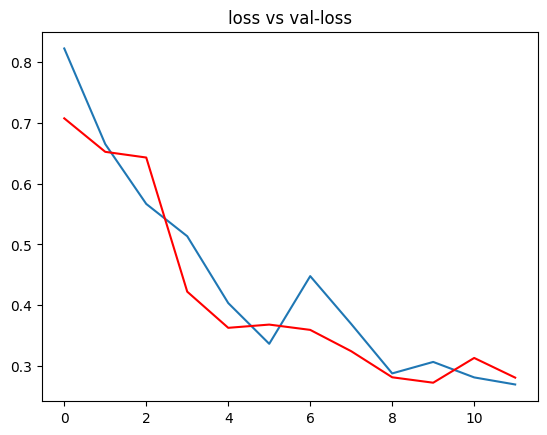

In [23]:
import matplotlib.pyplot as plt

plt.plot(h['loss'])
plt.plot(h['val_loss'], c="red")

plt.title("loss vs val-loss")
plt.show()

In [24]:
# Model Accuracy
from keras.models import load_model

model=load_model("/content/bestmodel.h5")

# Model Accuracy

In [25]:
acc=model.evaluate_generator(test_data)[1]
print(f"the accuracy of our model is {acc *100} %")

the accuracy of our model is 89.66131806373596 %


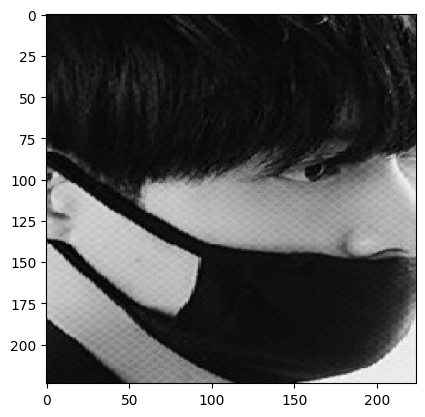

1/1 [==============================] - 2s 2s/step
The person in the image is wearing a mask


In [26]:
from keras.preprocessing.image import load_img, img_to_array

path="/content/data/with_mask/with_mask_1003.jpg"

img=load_img(path, target_size=(224,224))

input_arr=img_to_array(img)/255

plt.imshow(input_arr)
plt.show()
input_arr.shape

input_arr=np.expand_dims(input_arr,axis=0)

pred=(model.predict(input_arr)[0][0]> 0.5).astype("int32")

pred

if pred==0:
  print("The person in the image is wearing a mask")
else:
  print("The person in the image is not wearing a mask")

In [27]:
train_data.class_indices

{'with_mask': 0, 'without_mask': 1}

# Transformer Learning for Tuning

In [28]:
from keras.applications.mobilenet import MobileNet, preprocess_input

def preprocessingImages1(path):
  """
  input : Path
  output: Pre processing images
  """
  #image_data=ImageDataGenerator(zoom_range=0.2,shear_range=0.2, rescale=1/255, horizontal_flip=True)
  image_data=ImageDataGenerator(zoom_range=0.2,shear_range=0.2, preprocessing_function=preprocess_input, horizontal_flip=True) # for transformer learning

  image=image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size=64, class_mode='binary')

  return image

In [29]:
path="/content/train"
train_data=preprocessingImages1(path)

Found 5276 images belonging to 2 classes.


In [30]:
def preprocessingImages2(path):
  """
  input : Path
  output: Pre processing
  """
  #image_data=ImageDataGenerator(rescale=1/255)
  image_data=ImageDataGenerator(preprocessing_function=preprocess_input) # for transformer learning
  image=image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size=64, class_mode='binary')

  return image

In [31]:
path="/content/test"
test_data=preprocessingImages2(path)

Found 1122 images belonging to 2 classes.


In [32]:
path="/content/dev"
test_data=preprocessingImages2(path)

Found 1122 images belonging to 2 classes.


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet
import keras

In [34]:
base_model=MobileNet(input_shape=(224,224,3),include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [35]:
for layer in base_model.layers:
  layer.trainable=False

In [36]:
X=Flatten()(base_model.output)
X=Dense(units=1, activation='sigmoid')(X)

model=Model(base_model.input,X)


In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [38]:
model.compile(optimizer='rmsprop',
              loss=keras.losses.binary_crossentropy,
              metrics=['accuracy'])


In [39]:
## Call Back
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Eaarly stoppping

es=EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=7, verbose=1)

# model check point
mc=ModelCheckpoint(monitor='val_accuracy', filepath="./bestmodel.h5", verbose=1,save_best_only=True)

cb=[mc,es]

In [40]:
hist = model.fit_generator(generator=train_data,
                         steps_per_epoch=8,
                         epochs=30,
                         verbose=1,
                         validation_data=val_data,
                         validation_steps=14,
                         callbacks=cb )


Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 6.4710 - accuracy: 0.6797
Epoch 1: val_accuracy improved from -inf to 0.96429, saving model to ./bestmodel.h5
8/8 [==============================] - 17s 1s/step - loss: 6.4710 - accuracy: 0.6797 - val_loss: 0.1824 - val_accuracy: 0.9643
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.9805
Epoch 2: val_accuracy improved from 0.96429 to 0.97433, saving model to ./bestmodel.h5
8/8 [==============================] - 12s 2s/step - loss: 0.0984 - accuracy: 0.9805 - val_loss: 0.1190 - val_accuracy: 0.9743
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9805
Epoch 3: val_accuracy improved from 0.97433 to 0.98884, saving model to ./bestmodel.h5
8/8 [==============================] - 12s 2s/step - loss: 0.1166 - accuracy: 0.9805 - val_loss: 0.0607 - val_accuracy: 0.9888
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 

In [41]:
# Load the best fit model

model=load_model("/content/bestmodel.h5")

In [42]:
acc=model.evaluate_generator(test_data)[1]
print(f"the accuracy of our model is {acc *100} %")

the accuracy of our model is 99.10873174667358 %


In [43]:
h=hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

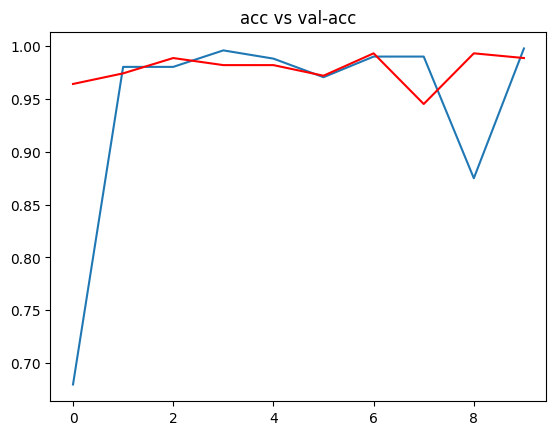

In [44]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c="red")

plt.title("acc vs val-acc")
plt.show()

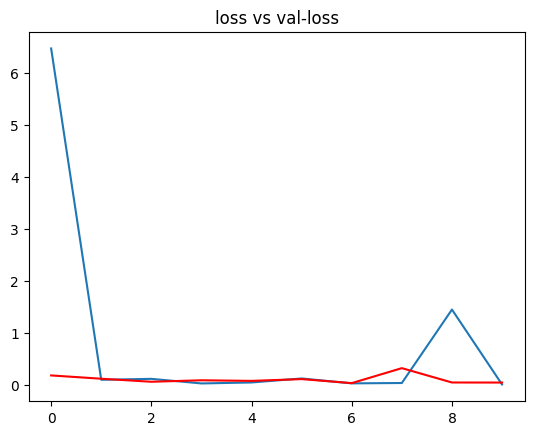

In [45]:
import matplotlib.pyplot as plt

plt.plot(h['loss'])
plt.plot(h['val_loss'], c="red")

plt.title("loss vs val-loss")
plt.show()

1/1 [==============================] - 1s 713ms/step


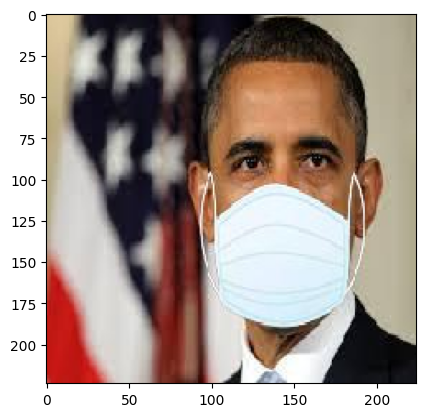

The person in the image is wearing a mask


In [46]:
from keras.preprocessing import image
path="/content/data/with_mask/with_mask_1004.jpg"

img=image.load_img(path, target_size=(224,224))

i=image.img_to_array(img)/255 # delet 255 and uncomment below command to see result
#i=preprocess_input(i)
input_arr=np.array([i])
input_arr.shape

pred=np.argmax(model.predict(input_arr))
pred

plt.imshow(input_arr[0])
plt.show()

if pred==0:
  print("The person in the image is wearing a mask")
else:
  print("The person in the image is not wearing a mask")